In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [3]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [4]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [5]:
tools=[wiki_tool]

In [6]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [7]:
from langgraph.graph import StateGraph,START,END

In [8]:
graph_builder= StateGraph(State)


In [9]:
from langchain_groq import ChatGroq

In [10]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")  # Ensure this is a string


In [11]:
llm = ChatGroq(api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b")

# print(llm)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x767ac127d4e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x767ac12a1390>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [12]:
llm_with_tools=llm.bind_tools(tools=tools)

In [13]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [14]:
from langgraph.prebuilt import ToolNode,tools_condition

In [15]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [16]:
graph=graph_builder.compile()

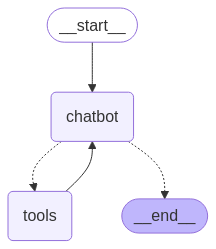

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================

Hello, John! How can I assist you today?


In [19]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================

RLHF stands for **Reinforcement Learning from Human Feedback**. It is a technique used in machine learning, particularly in training large language models, to improve their performance and alignment with human preferences. Here's a breakdown of the process:

1. **Human Feedback Collection**: Human evaluators assess and rank various responses generated by the model to a given prompt. This feedback helps identify which responses are more desirable or coherent.

2. **Reward Model Training**: The collected human feedback is used to train a reward model. This model learns to predict the likelihood that a given response will be favored by humans.

3. **Reinforcement Learning**: The language model is then fine-tuned using reinforcement learning, where it optimizes for the reward signal provided by the reward model. Th

In [22]:
# Import required modules
from langchain_core.messages import AIMessage, HumanMessage

# Initialize chat history
chat_history = []

# Start the chat loop
while True:
    user_input = input("You: ")  # Take user input

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Chatbot: Goodbye!")
        break  # Exit the loop if the user wants to quit

    # Append the user's message to the chat history
    chat_history.append(HumanMessage(user_input))

    # Generate a response
    events = graph.stream({"messages": chat_history}, stream_mode="values")

    # Collect chatbot response
    chatbot_response = ""
    for event in events:
        # Get the chatbot response, ignoring irrelevant content like "Page" or summaries
        content = event["messages"][-1].content
        if "Page" not in content and len(content.strip()) > 0:
            chatbot_response += content.strip()

    # Ensure that chatbot response is valid and does not contain "Page" or summaries
    if chatbot_response:
        # Print the dialogue in the correct format
        print(f"You: {user_input}")
        print(f"Chatbot: {chatbot_response}")
    else:
        print("Chatbot: I'm sorry, I couldn't find a response to that.")

    # Append AI response to chat history to maintain context
    chat_history.append(AIMessage(chatbot_response))


You: What is the Asus Zephyrus laptop series?
Chatbot: What is the Asus Zephyrus laptop series?The Asus Zephyrus series is a line of high-performance gaming laptops produced by Asus under its Republic of Gamers (ROG) brand. Named after Zephyr, the Greek god of the west wind, these laptops are designed to be thin, lightweight, and powerful, catering to gamers who seek both portability and strong performance.

The Zephyrus series was one of the first to utilize NVIDIA's Max-Q design approach, which allows for the creation of slim gaming laptops without compromising on graphical performance. These laptops typically feature high-resolution displays with high refresh rates, powerful processors (often from Intel or AMD), and dedicated NVIDIA graphics cards.

Key features of the Zephyrus series include:

1. **Thin and Lightweight Design**: Despite their gaming capabilities, Zephyrus laptops are known for their sleek, compact designs, making them easier to carry around.

2. **High-Performance 